In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import plot_model
from keras.preprocessing import image
import pickle
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random 
import time

from google.colab import drive
drive.mount('/content/drive') #Link Google Colab to Google Drive

IMG_SIZE = 120 #Image size for the entire system (Model, Training set, Testing set etc)
DATADIR = "/content/drive/My Drive/Colab Notebooks/Training-Data" #Directory for the dataset
CATEGORIES = ["surprise","anger","disgust","fear", "joy","sadness"] #Emotions (Classes) the model is trained on and can predict
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/Cascade-Classifier/haarcascade_frontalface_default.xml') #The Face Haar Cascade Classifier

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Haar Cascade function - Each image in the dataset is Haar Cascaded (cropped) and converted to grayscale
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    image = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(image, 1.30, 0)
    for(x,y,w,h) in faces:
      roi_gray = image[y:y+h, x:x+w]
      crop = image[y:y+h,  x:x+w]
      check = cv2.imwrite(os.path.join(path,img), crop)
   

In [0]:
#Read dataset images. Store the images to a numpy array
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break
  break  


In [0]:
def flipTrainingImage(imageArray, method): #Flip Images vertically and horizontally
  code = 0
  if(method == "V"):
    code = 1
  flipArray = cv2.flip(imageArray, code)
  return flipArray

def rotateTrainingImage(imageArray, angle): #Rotate Images clockwise and counter, and upside down clockwise
  # rotate cw
  code = 0
  if(angle == 90):
    code = 1 
  elif(angle == 180):
    code = -1
    
  if(angle != 180):
    rotatedArray=cv2.transpose(imageArray)
    rotatedArray=cv2.flip(rotatedArray,flipCode=code)
  else:
    rotatedArray=cv2.flip(imageArray,flipCode=code)
    
  return rotatedArray

def noiseTrainingImage(imageArray,quantity): #Add salt and pepper noise to image
    output = np.zeros(imageArray.shape,np.uint8)
    thres = 1 - quantity 
    for i in range(imageArray.shape[0]):
        for j in range(imageArray.shape[1]):
            rdn = random.random()
            if rdn < quantity:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = imageArray[i][j]
    return output
  
def translationTrainingImage(imageArray, direction): #Applying translation to the image (certain fraction is cropped) - each direction alters the image differently
  (HEIGHT,WIDTH) = imageArray.shape
  # Shifting Left
  if(direction == "left"):
    for i in range(HEIGHT, 1, -1):
      for j in range(WIDTH):
         if (i < HEIGHT-20):
           imageArray[j][i] = imageArray[j][i-20]
         elif (i < HEIGHT-1):
           imageArray[j][i] = 0
  # Shifting Right
  elif(direction == "right"):
    for j in range(WIDTH):
      for i in range(HEIGHT):
        if (i < HEIGHT-20):
          imageArray[j][i] = imageArray[j][i+20]
  # Shifting Top          
  elif(direction == "top"):
    for j in range(WIDTH):
      for i in range(HEIGHT):
        if (j < WIDTH - 20 and j > 20):
          imageArray[j][i] = imageArray[j+20][i]
        else:
          imageArray[j][i] = 0
  # Shifting Down
  elif(direction == "down"):
    for j in range(WIDTH, 1, -1):
      for i in range(HEIGHT):
        if (j < IMG_SIZE and j > 20):
          imageArray[j][i] = imageArray[j-20][i]
          
  return imageArray
  

In [0]:
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #Ensure the image is grayscale
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #Resize Image to 120x120 pixels
          #Original Image
          training_data.append([new_array, class_num])

          # Augmented Data
          flipV_array = flipTrainingImage(new_array, "V")
          flipH_array = flipTrainingImage(new_array, "H")
          flip90_array = rotateTrainingImage(new_array,90)
          flip180_array = rotateTrainingImage(new_array,180)
          flip270_array = rotateTrainingImage(new_array,270)
          noise_array = noiseTrainingImage(new_array,0.02)
          
          flipV90_array = flipTrainingImage(flip90_array, "V")
          flipV270_array = flipTrainingImage(flip270_array, "V")
          flipV180_array = flipTrainingImage(flip180_array, "V")
          flipH90_array = flipTrainingImage(flip90_array, "H")
          flipH270_array = flipTrainingImage(flip270_array, "H")
          flipH180_array = flipTrainingImage(flip180_array, "H")
          
          translationL_array = translationTrainingImage(new_array,"left") 
          translationR_array = translationTrainingImage(new_array,"right") 
          translationT_array = translationTrainingImage(new_array,"top") 
          translationD_array = translationTrainingImage(new_array,"down") 

          #Appending Augmented Data to the Training set
          training_data.append([flipV_array, class_num])
          training_data.append([flipH_array, class_num])
          training_data.append([flip90_array, class_num])
          training_data.append([flip180_array, class_num])
          training_data.append([flip270_array, class_num])
          training_data.append([noise_array, class_num])
          
          training_data.append([flipV90_array, class_num])
          training_data.append([flipV270_array, class_num])
          training_data.append([flipV180_array, class_num])
          training_data.append([flipH180_array, class_num])
          training_data.append([flipH90_array, class_num])
          training_data.append([flipH270_array, class_num])
          
          training_data.append([translationL_array, class_num])
          training_data.append([translationR_array, class_num])
          training_data.append([translationT_array, class_num])
          training_data.append([translationD_array, class_num])

      except Exception as e:
          pass


In [0]:
create_training_data()
print(len(training_data))
random.shuffle(training_data)

X = [] #features
y = [] #labels
for features,label in training_data:
  X.append(features)
  y.append(label)
  
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)

pickle_out = open("/content/drive/My Drive/Colab Notebooks/Training-Set/X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close();
pickle_out = open("/content/drive/My Drive/Colab Notebooks/Training-Set/y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close();


In [0]:
#Execute this cell to load the pickle files, instead of having to train, augment and save the data to pixel files (This step is only possible if the pickle files exist and are up to date)
pickle_in = open("/content/drive/My Drive/Colab Notebooks/Training-Set/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Colab Notebooks/Training-Set/y.pickle","rb")
y = pickle.load(pickle_in)

print(len(X))


In [0]:
#CNN Model Architecture

#Optimum Model
#dense_layers = [0]
#layer_sizes = [64]
#conv_layers = [4]

#Comprehensive Testing Values 
dense_layers = [0,1,2,3]
layer_sizes = [32,64]
conv_layers = [1,2,3,4]

time = int(time.time())
X=X/255 #Normalise the data

for dense_layer in dense_layers:
  for layer_size in layer_sizes:
    for conv_layer in conv_layers:
      NAME = f'{conv_layer}-convLayers-{layer_size}-nodes-{dense_layer}-dense-time' #Unique model name to distinguish between models
      print(NAME) #Name is printed to visualise which model is being trained
      tensorboard = TensorBoard(log_dir=f'/content/drive/My Drive/Colab Notebooks/Logs/{NAME}') #Records model statistics to be viewed via TensorBoard
      earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False) #controls the training time of the model (halts when overfitting)
      model = Sequential() #Sequential model structure

      #Convolutional Layers 
      model.add(Conv2D(layer_size,(3,3), input_shape = X.shape[1:]))
      model.add(Activation("relu"))
      model.add(MaxPooling2D(pool_size=(2,2)))
      
      for l in range(conv_layer-1):
        model.add(Conv2D(layer_size,(3,3)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
      model.add(Flatten()) #2D to 1D
      
      #Fully connected layer
      for l in range(dense_layer):
        model.add(Dense(layer_size))
        model.add(Activation("relu"))

      #Output Layer
      model.add(Dropout(0.2))
      model.add(Dense(6))
      model.add(Activation('softmax'))

      model.compile(
                   loss="sparse_categorical_crossentropy",
                   optimizer='adam',
                   metrics=['accuracy']
                   )
      
      history = model.fit(X, y, batch_size=64, epochs=25, validation_split=0.2, callbacks=[tensorboard,earlyStopping]) #Calllbacks are set when the model starts to train
      model.save(f'/content/drive/My Drive/Colab Notebooks/Model/{NAME}.model')
      # Plot training & validation accuracy values
      plt.plot(history.history['acc'])
      plt.plot(history.history['val_acc'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()
      plot_model(model, to_file='/content/drive/Colab Notebooks/My Drive/model.png', show_shapes=True) #View visual representation of the model
model.summary() #View summary of the model

In [4]:
#Select Model for predictions

#Load the trained model, alter the 'NAME' variable to change models
NAME = '4-convLayers-64-nodes-0-dense-time'
model = tf.keras.models.load_model(f'/content/drive/My Drive/Colab Notebooks/Model/{NAME}.model')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


joy - Likelihood: 0.753370
Predicted Emotion: joy
Suprise: 0.01
Anger: 0.06
Disgust: 0.03
Fear: 0.15
Joy: 0.75
Sadness: 0.0


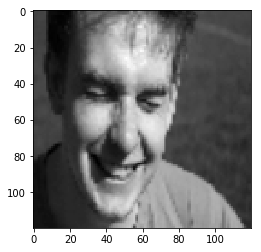

In [11]:
#Select Image to be predicted and visualise the result

#Image to be predicted by the model
file = '/content/drive/My Drive/Colab Notebooks/Live-Testing-Set/Jo/joy/jo_joy.JPG'
# Load an image file to test, resizing it to 120 x 120 pixels (as required by this model)
img = image.load_img(file, target_size=(IMG_SIZE, IMG_SIZE),color_mode = "grayscale")
#Convert image to numpy array
image_to_test = image.img_to_array(img)

#Haar Cascade
gray = np.array(image_to_test, dtype='uint8')
faces = face_cascade.detectMultiScale(gray, 1.10, 0)
for(x,y,w,h) in faces:
  roi_gray = gray[y:y+h, x:x+w]
  crop = gray[y:y+h,  x:x+w]
resized_image = cv2.resize(crop, (120, 120))   
image_to_test = image.img_to_array(resized_image)

# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
list_of_images = np.expand_dims(image_to_test, axis=0)
#Model Prediction 
prediction = model.predict(list_of_images)             
# Only one image is being tested, therefore the first result is stored in the single_result variable
single_result = prediction[0]

# Retrieve the class percentages for each of the six emotions. 
most_likely_class_index = int(np.argmax(single_result))
#Find out which class has the highest score.
class_likelihood = single_result[most_likely_class_index]
# Get the name of the most likely emotion
class_label = CATEGORIES[most_likely_class_index]

# Print the result
print("{} - Likelihood: {:2f}".format(class_label, class_likelihood))
print("Predicted Emotion: {}".format(class_label))
print("Suprise: " + str(float("{:.2f}".format(float(prediction[0][0])))))
print("Anger: " + str(float("{:.2f}".format(float(prediction[0][1])))))
print("Disgust: " + str(float("{:.2f}".format(float(prediction[0][2])))))
print("Fear: " + str(float("{:.2f}".format(float(prediction[0][3])))))
print("Joy: " + str(float("{:.2f}".format(float(prediction[0][4])))))
print("Sadness: " + str(float("{:.2f}".format(float(prediction[0][5])))))

plt.imshow(resized_image, cmap='gray')